# PCA and the US Treasury Yield Curve  
by Zun Cao

We’ll download constant-maturity Treasury yields from the St. Louis Fed (**FRED**), run
Principal Component Analysis (PCA), and show that three orthogonal “factors” (level, slope, curvature) explain almost all daily curve movements.

**Steps**

1. Grab daily yields (1 M → 30 Y).  
2. Apply PCA and look at cumulative explained variance.  
3. Visualise factor loadings and give the economic intuition.  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from sklearn.decomposition import PCA


# FRED tickers for constant-maturity Treasuries
tickers = {
    "DGS1MO": "1M",
    "DGS3MO": "3M",
    "DGS6MO": "6M",
    "DGS1":   "1Y",
    "DGS2":   "2Y",
    "DGS3":   "3Y",
    "DGS5":   "5Y",
    "DGS7":   "7Y",
    "DGS10":  "10Y",
    "DGS20":  "20Y",
    "DGS30":  "30Y",
}

# download (2006-01-01 onward) & clean
start = "2006-01-01"
df_raw = web.DataReader(list(tickers), "fred", start)
df = df_raw.rename(columns=tickers).dropna()

display(df.tail())

,1M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
DATE,,,,,,,,,,,
2025-07-23,4.37,4.41,4.31,4.08,3.88,3.84,3.94,4.15,4.40,4.93,4.95
2025-07-24,4.37,4.42,4.32,4.10,3.91,3.87,3.98,4.18,4.43,4.95,4.96
2025-07-25,4.37,4.42,4.31,4.09,3.91,3.86,3.95,4.15,4.40,4.92,4.92
2025-07-28,4.40,4.40,4.30,4.09,3.91,3.87,3.96,4.18,4.42,4.95,4.96
2025-07-29,4.40,4.40,4.28,4.07,3.86,3.82,3.90,4.10,4.34,4.86,4.86


## 1. Quick sanity check

A heat-map of pairwise correlations confirms that **all yields move together**, with correlation decreasing as maturities grow further apar.


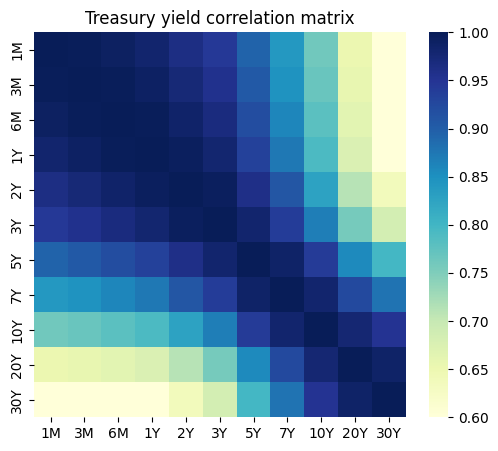

In [4]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(df.corr(), cmap="YlGnBu", vmin=0.6, vmax=1, annot=False)
plt.title("Treasury yield correlation matrix")
plt.show()

## 2. Run PCA

We fit PCA on the *levels* (no de-meaning/standardisation needed because all series are yields in % already).

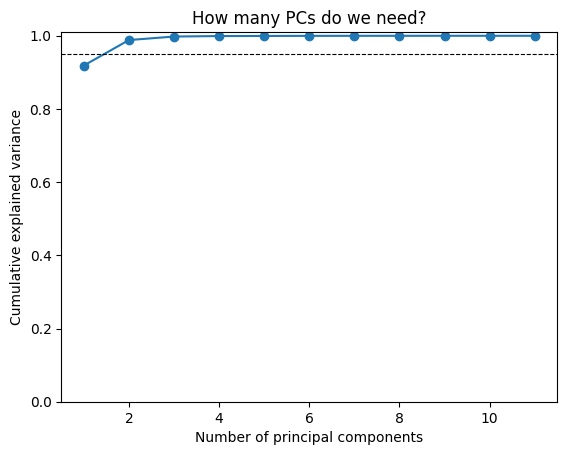

Variance explained by first 3 PCs: 0.9979


In [5]:
pca = PCA().fit(df)

# cumulative variance plot
plt.plot(np.arange(1, 12), pca.explained_variance_ratio_.cumsum(), marker="o")
plt.axhline(0.95, ls="--", c="k", lw=0.8)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("How many PCs do we need?")
plt.ylim(0, 1.01)
plt.show()

print("Variance explained by first 3 PCs:",
      pca.explained_variance_ratio_[:3].sum().round(4))

### Result  
The first three PCs usually explain **> 99 %** of the curve’s daily variance — exactly what the literature finds (Litterman & Scheinkman, 1991).

C:\Users\13464\AppData\Local\Temp\ipykernel_28692\89431683.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45)
C:\Users\13464\AppData\Local\Temp\ipykernel_28692\89431683.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45)
C:\Users\13464\AppData\Local\Temp\ipykernel_28692\89431683.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45)


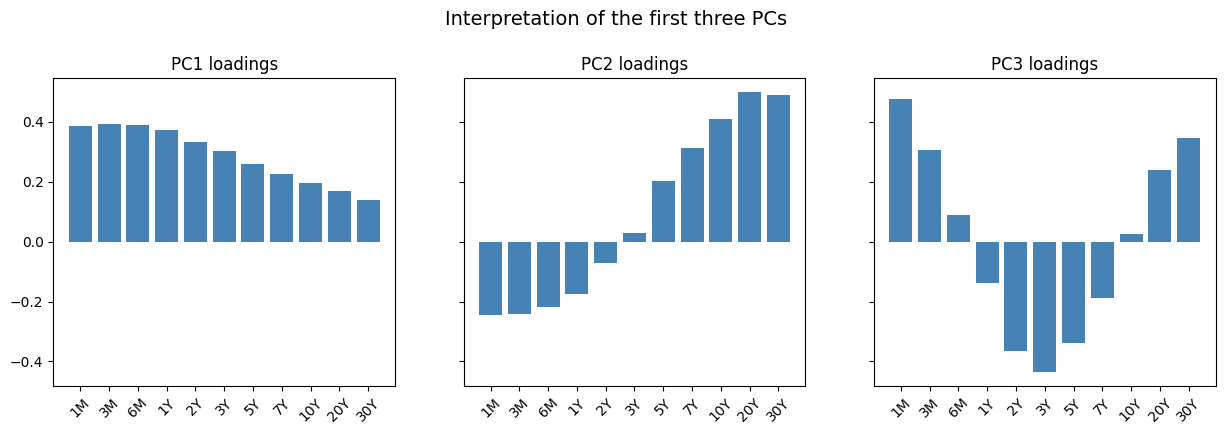

In [6]:
labels = df.columns.tolist()
fig, ax = plt.subplots(1, 3, figsize=(15,4), sharey=True)

for i in range(3):
    ax[i].bar(labels, pca.components_[i], color="steelblue")
    ax[i].set_title(f"PC{i+1} loadings")
    ax[i].set_xticklabels(labels, rotation=45)

fig.suptitle("Interpretation of the first three PCs", y=1.05, fontsize=14)
plt.show()

### 3. Economic intuition

* **PC 1 — Level:** All tenors load with the same sign → parallel shift of the curve.  
* **PC 2 — Slope/Spread:** Short rates vs. long rates move in opposite directions → curve steepens or flattens.  
* **PC 3 — Curvature/Butterfly:** Wings (short & long) load against the belly → captures changes in “humpiness”.

These three factors form the common **Level–Slope–Curvature** decomposition widely used in fixed-income risk models.


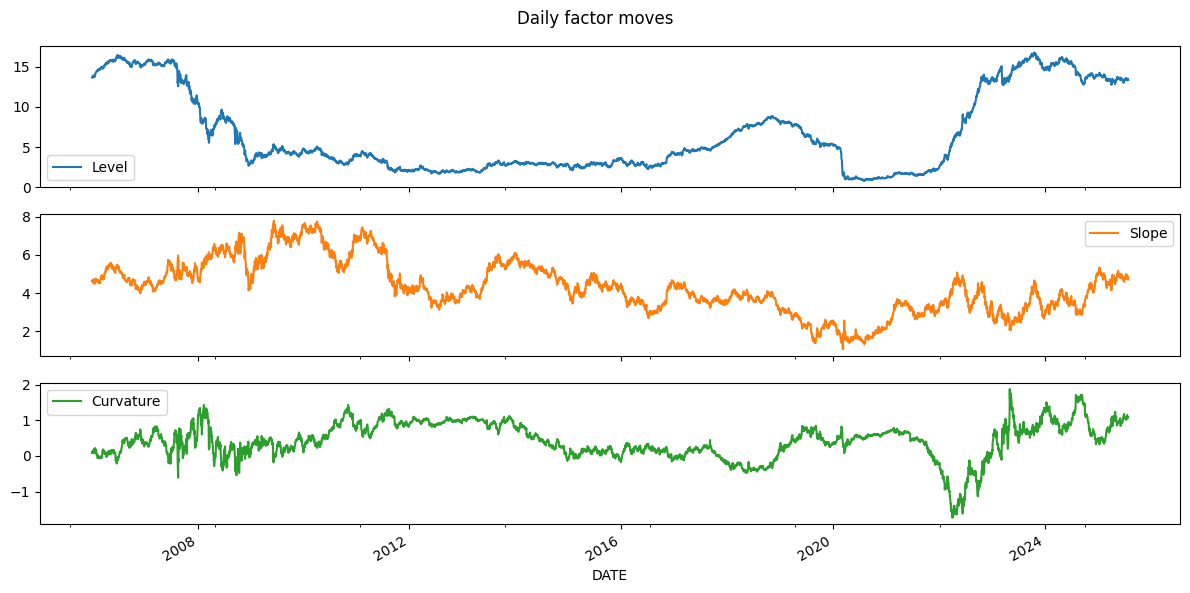

In [7]:
factors = pd.DataFrame(
    data = df.values @ pca.components_[:3].T,
    index = df.index,
    columns = ["Level", "Slope", "Curvature"]
)
factors.plot(subplots=True, figsize=(12,6), title="Daily factor moves")
plt.tight_layout()
plt.show()

## Take-aways

* 11 correlated yields → 3 orthogonal factors with ~99 % explanatory power.  
* Traders often **approximate** PC portfolios:
  * Slope ≈ 2 × 10-year – 2-year  
  * Curvature ≈ (2 × 5-year – 10-year – 2-year)  
* PCA is equally useful for swap curves, credit curves, or any term-structure style dataset.